In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings to make output cleaner

In [2]:

# Load the dataset
file_path = "C:/Users/45227/Desktop/SEMINARFIN/fulldata.csv"
data = pd.read_csv(file_path)

In [19]:
# Convert the 'from' and 'to' columns to datetime
data['from'] = pd.to_datetime(data['from'])
data['to'] = pd.to_datetime(data['to'])

# Format the datetime columns to include only date and hour
data['from'] = data['from'].dt.strftime('%Y-%m-%d %H:00')
data['to'] = data['to'].dt.strftime('%Y-%m-%d %H:00')

print(data[['from', 'to']].head())

                    from                to
118591  2011-04-10 22:00  2011-04-10 23:00
118592  2011-04-10 21:00  2011-04-10 22:00
118593  2011-04-10 20:00  2011-04-10 21:00
118594  2011-04-10 19:00  2011-04-10 20:00
118595  2011-04-10 18:00  2011-04-10 19:00


In [5]:

# Filter relevant columns
spot_price = data['SpotPriceDKK']
weather_columns = [col for col in data.columns if 'mean_temp' in col or 'wind' in col]
weather_data = data[weather_columns]

# Limit data to the last 100 days (assuming hourly data, 24 hours per day)
data = data.tail(100 * 24)
spot_price = spot_price.tail(100 * 24)
weather_data = weather_data.tail(100 * 24)

In [6]:
# Limit data to the last 100 days (assuming hourly data, 24 hours per day)
data = data.tail(100 * 24)
spot_price = spot_price.tail(100 * 24)
weather_data = weather_data.tail(100 * 24)

In [7]:
# Handle missing or zero values in spot prices
spot_price = spot_price.replace(0, np.nan)  # Replace zeros with NaN
spot_price.fillna(method='ffill', inplace=True)  # Forward fill missing values
spot_price.fillna(spot_price.mean(), inplace=True)  # Replace any remaining NaN with the mean value

# Handle missing values in weather data
weather_data.fillna(method='ffill', inplace=True)
weather_data.fillna(weather_data.mean(), inplace=True)

In [8]:
# Create new variables for wind speed in each direction
wind_speed_columns = [col for col in weather_data.columns if 'wind_speed' in col]
wind_direction_columns = [col for col in weather_data.columns if 'wind_dir' in col]

for speed_col in wind_speed_columns:
    for dir_col in wind_direction_columns:
        if speed_col.split('_')[-1] == dir_col.split('_')[-1]:  # Matching columns for the same kommune
            weather_data[f'{speed_col}_in_{dir_col}'] = weather_data[speed_col] * weather_data[dir_col]

In [9]:
# Standardize the weather data
scaler = StandardScaler()
weather_data_scaled = scaler.fit_transform(weather_data)

In [11]:
# Predict each hour using data from the previous 24 hours and weather data
train_size = len(spot_price) - 24
predictions = []

for i in range(train_size, len(spot_price)):
    # Use the previous 24 hours to predict the next hour
    train_data = spot_price[i - 24:i]
    exog_train = weather_data_scaled[i - 24:i]
    model = ARIMA(train_data, order=(1, 1, 1), exog=exog_train)
    model_fit = model.fit()
    exog_forecast = weather_data_scaled[i].reshape(1, -1)  # Use current weather data for forecast
    forecast = model_fit.forecast(steps=1, exog=exog_forecast)
    predictions.append(forecast.iloc[0])  # Use iloc[0] to access the value correctly

# Convert predictions to a numpy array
predictions = np.array(predictions)

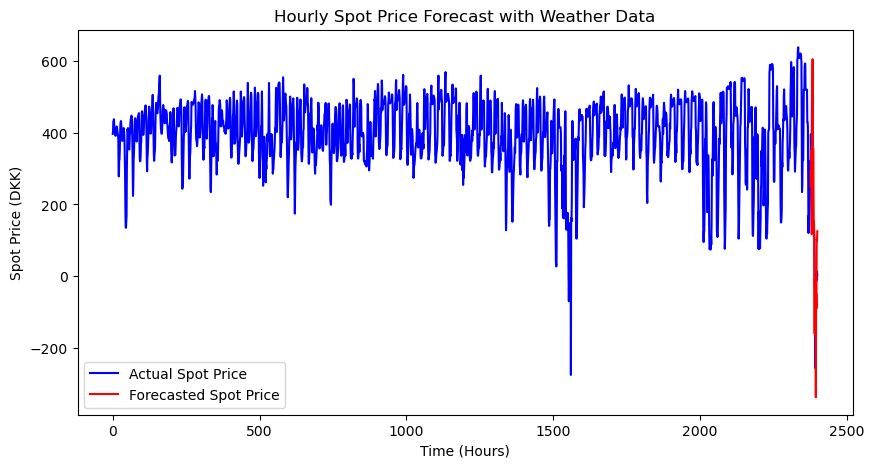

In [21]:
# Plot the forecast vs actual values
plt.figure(figsize=(10, 5))
plt.plot(range(len(spot_price)), spot_price, label='Actual Spot Price', color='blue')
plt.plot(range(train_size, len(spot_price)), predictions, label='Forecasted Spot Price', color='red')
plt.xlabel('Time (Hours)')
plt.ylabel('Spot Price (DKK)')
plt.title('Hourly Spot Price Forecast with Weather Data')
plt.legend()
plt.show()

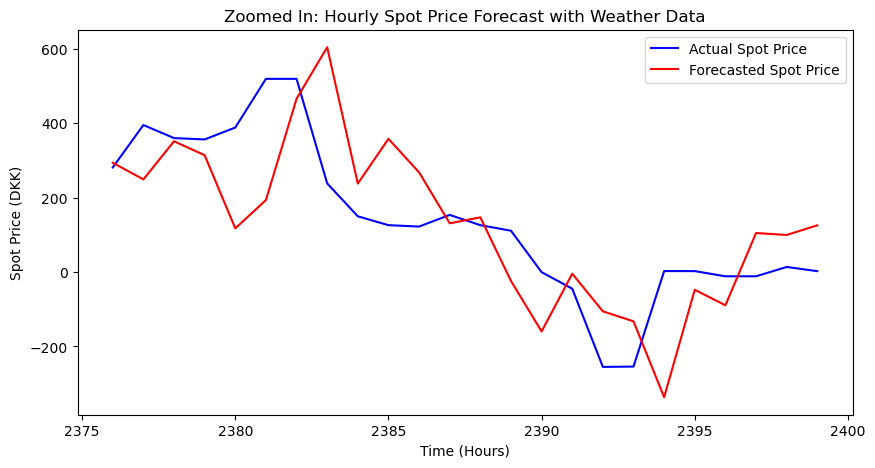

In [20]:
# Zoom in on the predicted part of the plot
plt.figure(figsize=(10, 5))
plt.plot(range(train_size, len(spot_price)), spot_price[train_size:], label='Actual Spot Price', color='blue')
plt.plot(range(train_size, len(spot_price)), predictions, label='Forecasted Spot Price', color='red')
plt.xlabel('Time (Hours)')
plt.ylabel('Spot Price (DKK)')
plt.title('Zoomed In: Hourly Spot Price Forecast with Weather Data')
plt.legend()
plt.show()